<a href="https://colab.research.google.com/github/brianramos/tsp/blob/master/SoftMaxSimulatedAnnealingTSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Brute-force search for two-argument expressions that match Apery’s constant ζ(3).

Key points
-----------
• Thread pool with bounded “sliding window” submission (no huge upfront queue).
• 30-second timeout per evaluation.
• tqdm progress bar that never disappears.
"""

import mpmath as mp
import itertools, bisect, time, os, threading
import concurrent.futures as cf
from tqdm.auto import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────
TARGET_PRECISION_DPS     = 15
TIMEOUT_SECONDS_PER_CALL = 30
MAX_WORKERS              = max(2, (os.cpu_count() or 2) * 2)
WINDOW                   = MAX_WORKERS * 5         # in-flight futures

LEADERBOARD_INTERVAL_SECONDS = 30
LEADERBOARD_TOP_N            = 10
INTEGER_N_RANGE              = range(1, 11)       # n = 1 … 100
# ─────────────────────────────────────────────────────────────────────────────

mp.mp.dps = TARGET_PRECISION_DPS
PI_MP, APERYS_CONSTANT_MP = mp.pi, mp.zeta(3)
TOL_ABS = mp.power(10, -(TARGET_PRECISION_DPS - 7))
TOL_REL = TOL_ABS

print(f"Precision: {mp.mp.dps} dps")
print(f"Timeout per call: {TIMEOUT_SECONDS_PER_CALL}s")
print(f"Workers: {MAX_WORKERS}\n")

# ── helper to turn mp numbers into ints where required ──────────────────────
def to_int_arg(x, *, non_negative=False, positive=False):
    if not mp.isfinite(x):
        raise ValueError("Non-finite")
    val = int(mp.nint(x))
    if non_negative and val < 0:
        raise ValueError("Need ≥0")
    if positive and val <= 0:
        raise ValueError("Need >0")
    return val

# ── build unary / binary templates (same as before, omitted for brevity) ────
mp_unary_ops = [
    ("({0})",           lambda x: x),
    ("-({0})",          lambda x: -x),
    ("mp.fabs({0})",    mp.fabs),
    ("mp.exp({0})",     mp.exp),
    ("mp.log({0})",     mp.log),
    ("mp.log10({0})",   mp.log10),
    ("mp.expm1({0})",   mp.expm1),
    ("mp.log1p({0})",   mp.log1p),
    ("mp.sqrt({0})",    mp.sqrt),
    ("mp.cbrt({0})",    mp.cbrt),
    ("mp.sin({0})",     mp.sin),
    ("mp.cos({0})",     mp.cos),
    ("mp.tan({0})",     mp.tan),
    ("mp.asin({0})",    mp.asin),
    ("mp.acos({0})",    mp.acos),
    ("mp.atan({0})",    mp.atan),
    ("mp.sec({0})",     mp.sec),
    ("mp.csc({0})",     mp.csc),
    ("mp.cot({0})",     mp.cot),
    ("mp.sinh({0})",    mp.sinh),
    ("mp.cosh({0})",    mp.cosh),
    ("mp.tanh({0})",    mp.tanh),
    ("mp.asinh({0})",   mp.asinh),
    ("mp.acosh({0})",   mp.acosh),
    ("mp.atanh({0})",   mp.atanh),
    ("mp.sech({0})",    mp.sech),
    ("mp.csch({0})",    mp.csch),
    ("mp.coth({0})",    mp.coth),
    ("mp.gamma({0})",   mp.gamma),
    ("mp.rgamma({0})",  mp.rgamma),
    ("mp.loggamma({0})",mp.loggamma),
    ("mp.psi(0,{0})",   lambda x: mp.psi(0, x)),
    ("mp.erf({0})",     mp.erf),
    ("mp.erfc({0})",    mp.erfc),
    ("mp.erfi({0})",    mp.erfi),
    ("mp.floor({0})",   mp.floor),
    ("mp.ceil({0})",    mp.ceil),
    ("mp.nint({0})",    mp.nint),
    ("mp.sinc({0})",    mp.sinc),
]

mp_binary_ops = [
    ("({0}+{1})",        lambda x, y: x + y,  True),
    ("({0}-{1})",        lambda x, y: x - y,  False),
    ("({0}*{1})",        lambda x, y: x * y,  True),
    ("({0}/{1})",        lambda x, y: x / y,  False),
    ("mp.power({0},{1})",mp.power,           False),
    ("mp.fmod({0},{1})", mp.fmod,            False),
    ("mp.hypot({0},{1})",mp.hypot,           True),
    ("mp.atan2({0},{1})",mp.atan2,           False),
    ("mp.beta({0},{1})", mp.beta,            True),


]

# ---------------------------------------------------------------------------
# Systematically generate unique candidate two-arg functions
# ---------------------------------------------------------------------------
candidate_funcs = []

# 1.  B(a,b)  + swapped if nonsymmetric
for tpl, fn, _ in mp_binary_ops:
    candidate_funcs.append((tpl.format("a", "b"), lambda a,b,_fn=fn: _fn(a,b)))
    swapped_tpl = tpl.format("b", "a")
    if swapped_tpl != tpl.format("a","b").replace("a","_A_").replace("b","a").replace("_A_","b"):
        candidate_funcs.append((swapped_tpl, lambda a,b,_fn=fn: _fn(b,a)))

# 2.  U(B(a,b))
for u_tpl, u_fn in mp_unary_ops:
    if u_tpl == "({0})":       # skip identity wrapper
        continue
    for b_tpl, b_fn, _ in mp_binary_ops:
        candidate_funcs.append(
            (u_tpl.format(b_tpl.format("a", "b")),
             lambda a,b,_u=u_fn,_b=b_fn: _u(_b(a,b))))
        swapped_tpl = b_tpl.format("b","a")
        if swapped_tpl != b_tpl.format("a","b").replace("a","_A_").replace("b","a").replace("_A_","b"):
            candidate_funcs.append(
                (u_tpl.format(swapped_tpl),
                 lambda a,b,_u=u_fn,_b=b_fn: _u(_b(b,a))))

# 3.  B(U(a),b) / B(a,U(b)) / swapped versions
for b_tpl, b_fn, _ in mp_binary_ops:
    for u_tpl, u_fn in mp_unary_ops:
        if u_tpl == "({0})":
            continue
        candidate_funcs.append(
            (b_tpl.format(u_tpl.format("a"), "b"),
             lambda a,b,_u=u_fn,_b=b_fn: _b(_u(a), b)))
        candidate_funcs.append(
            (b_tpl.format("a", u_tpl.format("b")),
             lambda a,b,_u=u_fn,_b=b_fn: _b(a, _u(b))))
        swapped_tpl = b_tpl.format("b","a")
        if swapped_tpl != b_tpl.format("a","b").replace("a","_A_").replace("b","a").replace("_A_","b"):
            candidate_funcs.append(
                (b_tpl.format(u_tpl.format("b"), "a"),
                 lambda a,b,_u=u_fn,_b=b_fn: _b(_u(b), a)))
            candidate_funcs.append(
                (b_tpl.format("b", u_tpl.format("a")),
                 lambda a,b,_u=u_fn,_b=b_fn: _b(b, _u(a))))

# 4.  B(U1(a),U2(b)) / swapped
for b_tpl, b_fn, _ in mp_binary_ops:
    for u1_tpl, u1_fn in mp_unary_ops:
        if u1_tpl == "({0})":
            continue
        for u2_tpl, u2_fn in mp_unary_ops:
            if u2_tpl == "({0})":
                continue
            candidate_funcs.append(
                (b_tpl.format(u1_tpl.format("a"), u2_tpl.format("b")),
                 lambda a,b,_u1=u1_fn,_u2=u2_fn,_b=b_fn: _b(_u1(a), _u2(b))))
            swapped_tpl = b_tpl.format("b","a")
            if swapped_tpl != b_tpl.format("a","b").replace("a","_A_").replace("b","a").replace("_A_","b"):
                candidate_funcs.append(
                    (b_tpl.format(u1_tpl.format("b"), u2_tpl.format("a")),
                     lambda a,b,_u1=u1_fn,_u2=u2_fn,_b=b_fn: _b(_u1(b), _u2(a))))

# Deduplicate (keep last occurrence of each textual template)
candidate_funcs = list({tpl:fn for tpl,fn in reversed(candidate_funcs)}.items())
print(f"Total generated candidate functions: {len(candidate_funcs)}\n")
# ── timeout wrapper ----------------------------------------------------------
class Timeout(RuntimeError): ...

def call_with_timeout(fn, a, b, *, limit):
    result_box, exc_box = {}, {}
    def run():
        try:
            result_box["val"] = fn(a, b)
        except Exception as e:
            exc_box["exc"] = e
    t = threading.Thread(target=run, daemon=True)
    t.start(); t.join(limit)
    if t.is_alive():
        return None, True          # timeout flag
    if exc_box:
        raise exc_box["exc"]
    return result_box["val"], False

# ── evaluation of ONE expression call ---------------------------------------
def eval_one(template, fn, a_val, b_val, a_txt, b_txt):
    try:
        with mp.workdps(TARGET_PRECISION_DPS + 5):
            res, tout = call_with_timeout(fn, a_val, b_val,
                                          limit=TIMEOUT_SECONDS_PER_CALL)
        if tout:
            return ("TIMEOUT", template, a_txt, b_txt)

        if hasattr(res, "imag") and mp.fabs(res.imag) > TOL_ABS:
            return None
        v = res.real if hasattr(res, "real") else res
        if not mp.isfinite(v):
            return None
        if mp.almosteq(v, APERYS_CONSTANT_MP, abs_eps=TOL_ABS, rel_eps=TOL_REL):
            diff = mp.fabs(v - APERYS_CONSTANT_MP)
            call_txt = template.replace("a", a_txt).replace("b", b_txt)
            v_str   = mp.nstr(v, TARGET_PRECISION_DPS)
            d_short = mp.nstr(diff, 5)
            return ("MATCH", diff, call_txt, v_str, d_short)
    except (ValueError, TypeError, ZeroDivisionError, OverflowError):
        pass
    except Exception as e:
        return ("ERROR", template, a_txt, b_txt, type(e).__name__, str(e))
    return None

# ── task generator (lazy) ----------------------------------------------------
def tasks():
    for n in INTEGER_N_RANGE:
        n_mp = mp.mpf(n)
        inputs = [(PI_MP, n_mp, "π", str(n)),
                  (n_mp, PI_MP, str(n), "π")]
        for tpl, fn in candidate_funcs:
            for a_val, b_val, a_txt, b_txt in inputs:
                yield (tpl, fn, a_val, b_val, a_txt, b_txt)

total_evals = len(candidate_funcs) * len(INTEGER_N_RANGE) * 2

# ── shared state -------------------------------------------------------------
found     = []           # sorted by diff
seen_set  = set()
lock      = threading.Lock()
last_board = time.time()

def print_board():
    with lock:
        if not found: return
        tqdm.write("\n— Top matches —")
        for i,(d,call,v,d_short) in enumerate(found[:LEADERBOARD_TOP_N]):
            tqdm.write(f"{i+1:2d}. Δ {d_short:<10} | {call} = {v}")
        tqdm.write("——————————\n")

# ── bounded-window producer / consumer loop ----------------------------------
with cf.ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex, \
     tqdm(total=total_evals,
          desc="Evaluating",
          unit="eval",
          unit_scale=True,
          dynamic_ncols=True,
          mininterval=0.2) as bar:

    task_iter   = tasks()
    in_flight   = set()

    # prime the window
    try:
        for _ in range(WINDOW):
            t = next(task_iter)
            fut = ex.submit(eval_one, *t)
            in_flight.add(fut)
    except StopIteration:
        pass

    while in_flight:
        done, in_flight = cf.wait(in_flight,
                                  return_when=cf.FIRST_COMPLETED)
        for fut in done:
            bar.update(1)

            res = fut.result()
            if res is None:
                pass
            elif res[0] == "MATCH":
                _, diff, call_txt, v_str, d_short = res
                with lock:
                    if call_txt not in seen_set:
                        seen_set.add(call_txt)
                        bisect.insort(found, (diff, call_txt, v_str, d_short))
                tqdm.write(f"MATCH: {call_txt} = {v_str} (Δ {d_short})")
            elif res[0] == "TIMEOUT":
                _, tpl, a_txt, b_txt = res
                tqdm.write(f"TIMEOUT >{TIMEOUT_SECONDS_PER_CALL}s: {tpl} "
                           f"(a={a_txt}, b={b_txt})")
            elif res[0] == "ERROR":
                _, tpl, a_txt, b_txt, etype, emsg = res
                tqdm.write(f"ERROR [{etype}] in {tpl} (a={a_txt}, b={b_txt}): {emsg}")

            # refill the window
            try:
                t = next(task_iter)
                fut_new = ex.submit(eval_one, *t)
                in_flight.add(fut_new)
            except StopIteration:
                pass

            # periodic leaderboard
            now = time.time()
            if now - last_board >= LEADERBOARD_INTERVAL_SECONDS:
                print_board()
                last_board = now
                bar.refresh()

        bar.set_postfix_str(f"Matches={len(found)}", refresh=True)

# ── final output -------------------------------------------------------------
print_board()
print(f"Done. Total matches: {len(found)}")

Precision: 15 dps
Timeout per call: 30s
Workers: 4

Total generated candidate functions: 17149



Evaluating:   0%|          | 0.00/343k [00:00<?, ?eval/s]

Streaming output truncated to the last 5000 lines.
ERROR [AttributeError] in mp.atan2(mp.tanh(a),mp.atanh(b)) (a=π, b=8): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(b),mp.acos(a)) (a=π, b=8): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(b),mp.acos(a)) (a=8, b=π): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(a),mp.acos(b)) (a=8, b=π): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(a),mp.asin(b)) (a=8, b=π): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(a),mp.asin(b)) (a=π, b=8): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(a),mp.acos(b)) (a=π, b=8): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(b),mp.asin(a)) (a=8, b=π): 'mpc' object has no attribute '_mpf_'
ERROR [AttributeError] in mp.atan2(mp.tanh(b),mp.asin(a)) (a=π, b=8): 'mpc' object h

In [ ]:
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.special import softmax
from tqdm import tqdm
from IPython.display import display

# ─── 1. Embedded TSPLIB Data ──────────────────────────────────────────
berlin52_tsp = """
NAME: berlin52
TYPE: TSP
COMMENT: 52 locations in Berlin (Groetschel)
DIMENSION: 52
EDGE_WEIGHT_TYPE: EUC_2D
NODE_COORD_SECTION
1 565.0 575.0
2 25.0 185.0
3 345.0 750.0
4 945.0 685.0
5 845.0 655.0
6 880.0 660.0
7 25.0 230.0
8 525.0 1000.0
9 580.0 1175.0
10 650.0 1130.0
11 1605.0 620.0
12 1220.0 580.0
13 1465.0 200.0
14 1530.0 5.0
15 845.0 680.0
16 725.0 370.0
17 145.0 665.0
18 415.0 635.0
19 510.0 875.0
20 560.0 365.0
21 300.0 465.0
22 520.0 585.0
23 480.0 415.0
24 835.0 625.0
25 975.0 580.0
26 1215.0 245.0
27 1320.0 315.0
28 1250.0 400.0
29 660.0 180.0
30 410.0 250.0
31 420.0 555.0
32 575.0 665.0
33 1150.0 1160.0
34 700.0 580.0
35 685.0 595.0
36 685.0 610.0
37 770.0 610.0
38 795.0 645.0
39 720.0 635.0
40 760.0 650.0
41 475.0 960.0
42 95.0 260.0
43 875.0 920.0
44 700.0 500.0
45 555.0 815.0
46 830.0 485.0
47 1170.0 65.0
48 830.0 610.0
49 605.0 625.0
50 595.0 360.0
51 1340.0 725.0
52 1740.0 245.0
EOF
"""
eil51_tsp = """
NAME : eil51
COMMENT : 51-city problem (Christofides/Eilon)
TYPE : TSP
DIMENSION : 51
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 37 52
2 49 49
3 52 64
4 20 26
5 40 30
6 21 47
7 17 63
8 31 62
9 52 33
10 51 21
11 42 41
12 31 32
13 5 25
14 12 42
15 36 16
16 52 41
17 27 23
18 17 33
19 13 13
20 57 58
21 62 42
22 42 57
23 16 57
24 8 52
25 7 38
26 27 68
27 30 48
28 43 67
29 58 48
30 58 27
31 37 69
32 38 46
33 46 10
34 61 33
35 62 63
36 63 69
37 32 22
38 45 35
39 59 15
40 5 6
41 10 17
42 21 10
43 5 64
44 30 15
45 39 10
46 32 39
47 25 32
48 25 55
49 48 28
50 56 37
51 30 40
EOF
"""
st70_tsp = """
NAME: st70
TYPE: TSP
COMMENT: 70-city problem (Smith/Thompson)
DIMENSION: 70
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 64 96
2 80 39
3 69 23
4 72 42
5 48 67
6 58 43
7 81 34
8 79 17
9 30 23
10 42 67
11 7 76
12 29 51
13 78 92
14 64 8
15 95 57
16 57 91
17 40 35
18 68 40
19 92 34
20 62 1
21 28 43
22 76 73
23 67 88
24 93 54
25 6 8
26 87 18
27 30 9
28 77 13
29 78 94
30 55 3
31 82 88
32 73 28
33 20 55
34 27 43
35 95 86
36 67 99
37 48 83
38 75 81
39 8 19
40 20 18
41 54 38
42 63 36
43 44 33
44 52 18
45 12 13
46 25 5
47 58 85
48 5 67
49 90 9
50 41 76
51 25 76
52 37 64
53 56 63
54 10 55
55 98 7
56 16 74
57 89 60
58 48 82
59 81 76
60 29 60
61 17 22
62 5 45
63 79 70
64 9 100
65 17 82
66 74 67
67 10 68
68 48 19
69 83 86
70 84 94
EOF
"""
pr76_tsp = """
NAME : pr76
COMMENT : 76-city problem (Padberg/Rinaldi)
TYPE : TSP
DIMENSION : 76
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 3600 2300
2 3100 3300
3 4700 5750
4 5400 5750
5 5608 7103
6 4493 7102
7 3600 6950
8 3100 7250
9 4700 8450
10 5400 8450
11 5610 10053
12 4492 10052
13 3600 10800
14 3100 10950
15 4700 11650
16 5400 11650
17 6650 10800
18 7300 10950
19 7300 7250
20 6650 6950
21 7300 3300
22 6650 2300
23 5400 1600
24 8350 2300
25 7850 3300
26 9450 5750
27 10150 5750
28 10358 7103
29 9243 7102
30 8350 6950
31 7850 7250
32 9450 8450
33 10150 8450
34 10360 10053
35 9242 10052
36 8350 10800
37 7850 10950
38 9450 11650
39 10150 11650
40 11400 10800
41 12050 10950
42 12050 7250
43 11400 6950
44 12050 3300
45 11400 2300
46 10150 1600
47 13100 2300
48 12600 3300
49 14200 5750
50 14900 5750
51 15108 7103
52 13993 7102
53 13100 6950
54 12600 7250
55 14200 8450
56 14900 8450
57 15110 10053
58 13992 10052
59 13100 10800
60 12600 10950
61 14200 11650
62 14900 11650
63 16150 10800
64 16800 10950
65 16800 7250
66 16150 6950
67 16800 3300
68 16150 2300
69 14900 1600
70 19800 800
71 19800 10000
72 19800 11900
73 19800 12200
74 200 12200
75 200 1100
76 200 800
EOF
"""

def parse_tsp(text):
    coords, reading_coords = [], False
    for line in text.strip().splitlines():
        if line.strip().startswith("NODE_COORD_SECTION"): reading_coords = True; continue
        if line.strip().startswith("EOF"): break
        if reading_coords:
            parts = line.split()
            coords.append((float(parts[1]), float(parts[2])))
    return coords

instances_data = {
    "berlin52": parse_tsp(berlin52_tsp), "eil51": parse_tsp(eil51_tsp),
    "st70": parse_tsp(st70_tsp), "pr76": parse_tsp(pr76_tsp),
}
best_known = {"berlin52": 7542, "eil51": 426, "st70": 675, "pr76": 108159}

# ─── 2. TSP ALGORITHMS ──────────────────────────────────────────────────
class City:
    __slots__ = ("x", "y", "v")
    def __init__(self, x: float, y: float): self.x, self.y, self.v = x, y, False

def dist(c1, c2): return math.hypot(c1.x - c2.x, c1.y - c2.y)
def tour_len(tour): return sum(dist(tour[i], tour[i-1]) for i in range(len(tour)))

def nn(cities):
    for c in cities: c.v = False
    start_city = random.choice(cities)
    tour, current_city = [start_city], start_city
    start_city.v = True
    while len(tour) < len(cities):
        next_city = min((c for c in cities if not c.v), key=lambda c: dist(current_city, c))
        next_city.v = True
        tour.append(next_city)
        current_city = next_city
    return tour

def two_opt(tour):
    path, n = tour[:], len(tour)
    improved = True
    while improved:
        improved = False
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                if j - i == 1: continue
                if dist(path[i-1], path[j-1]) + dist(path[i], path[j]) < dist(path[i-1], path[i]) + dist(path[j-1], path[j]):
                    path[i:j] = path[j-1:i-1:-1]
                    improved = True
    return path

def three_opt(tour):
    path = tour[:]
    n = len(path)
    move_made = True
    pass_num = 0

    while move_made:
        move_made = False
        best_delta = 0
        best_move = None
        pass_num += 1

        # Create a new progress bar for each full O(n^3) pass
        while True:
            for i in range(n):
                for j in range(i + 2, n):
                    for k in range(j + 2, n + (1 if i > 0 else 0)):
                        if i == 0 and k == n: continue
                        k = k % n

                        # --- Check all 7 valid moves for this (i, j, k) triplet ---
                        A, B = path[i-1], path[i]
                        C, D = path[j-1], path[j]
                        E, F = path[k-1], path[k]

                        d0 = dist(A,B) + dist(C,D) + dist(E,F)

                        # Test all cases
                        d1 = dist(A,C) + dist(B,D) + dist(E,F)
                        d2 = dist(A,E) + dist(B,D) + dist(C,F)
                        d3 = dist(A,D) + dist(B,E) + dist(C,F)
                        d4 = dist(A,D) + dist(B,F) + dist(C,E)

                        if d1 - d0 < best_delta: best_delta, best_move = d1 - d0, (i, j, k, 1)
                        if d2 - d0 < best_delta: best_delta, best_move = d2 - d0, (i, j, k, 2)
                        if d3 - d0 < best_delta: best_delta, best_move = d3 - d0, (i, j, k, 3)
                        if d4 - d0 < best_delta: best_delta, best_move = d4 - d0, (i, j, k, 4)


        if best_move:
            i, j, k, case = best_move

            s1, s2, s3, s4 = path[:i], path[i:j], path[j:k], path[k:]

            if case == 1: path = s1 + s2[::-1] + s3 + s4
            elif case == 2: path = s1 + s3 + s2 + s4
            elif case == 3: path = s1 + s3[::-1] + s2 + s4
            elif case == 4: path = s1 + s2[::-1] + s3[::-1] + s4

            move_made = True

    return path


def calculate_distance(route_indices, distance_matrix):
    return distance_matrix[route_indices, np.roll(route_indices, -1)].sum()

def two_opt_swap(route_indices, i, k):
    return route_indices[:i] + route_indices[i:k+1][::-1] + route_indices[k+1:]

def entropic_sa(distance_matrix, initial_route_indices, max_iterations=1000):
    current_route, n = initial_route_indices[:], len(initial_route_indices)
    best_route = current_route[:]
    current_distance = calculate_distance(current_route, distance_matrix)
    best_distance = current_distance
    temperature, cooling_rate, min_temperature = 10.0, 0.995, 0.1

    for _ in range(max_iterations):
        distance_deltas, potential_swaps = [], []
        for _ in range(n):
            i = random.randint(1, n - 2)
            k = random.randint(i + 1, n - 1)
            old_dist = distance_matrix[current_route[i-1], current_route[i]] + distance_matrix[current_route[k], current_route[(k+1)%n]]
            new_dist = distance_matrix[current_route[i-1], current_route[k]] + distance_matrix[current_route[i], current_route[(k+1)%n]]
            distance_deltas.append(new_dist - old_dist)
            potential_swaps.append((i, k))

        probabilities = softmax(-np.array(distance_deltas) / temperature)
        selected_index = np.random.choice(len(potential_swaps), p=probabilities)
        i, k = potential_swaps[selected_index]
        new_route = two_opt_swap(current_route, i, k)
        new_distance = calculate_distance(new_route, distance_matrix)

        if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temperature):
            current_route, current_distance = new_route, new_distance
            if new_distance < best_distance:
                best_distance, best_route = new_distance, current_route[:]
        temperature = max(min_temperature, temperature * cooling_rate)
    return best_route

# ─── 3. BENCHMARKING & DATA COLLECTION ──────────────────────────────────
loops_set = [500, 2000]
runs = 3
records = []

for inst, coords in tqdm(instances_data.items(), desc="Processing Instances"):
    master_cities = [City(x, y) for x, y in coords]
    distance_matrix = cdist(np.array(coords), np.array(coords))
    city_to_idx = {id(c): i for i, c in enumerate(master_cities)}

    for r in tqdm(range(runs), desc=f"Runs for {inst}", leave=False):
        random.seed(6000 + r)
        shuffled_cities = random.sample(master_cities, len(master_cities))

        start_nn = time.perf_counter(); tour_nn = nn(shuffled_cities); time_nn = time.perf_counter() - start_nn
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_nn), "algo": "NN"})
        records.append({"instance": inst, "metric": "runtime", "value": time_nn, "algo": "NN"})

        start_2opt = time.perf_counter(); tour_2opt = two_opt(tour_nn); time_2opt = time.perf_counter() - start_2opt
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_2opt), "algo": "2-opt"})
        records.append({"instance": inst, "metric": "runtime", "value": time_2opt, "algo": "2-opt"})

        start_3opt = time.perf_counter(); tour_3opt = three_opt(tour_2opt); time_3opt = time.perf_counter() - start_3opt
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_3opt), "algo": "3-opt"})
        records.append({"instance": inst, "metric": "runtime", "value": time_3opt, "algo": "3-opt"})

        for loops in loops_set:
            start_pipeline = time.perf_counter()
            initial_indices = [city_to_idx[id(c)] for c in tour_2opt]
            sa_indices = entropic_sa(distance_matrix, initial_indices, max_iterations=loops)
            sa_tour = [master_cities[i] for i in sa_indices]
            final_polished_tour = two_opt(sa_tour)
            time_pipeline = time.perf_counter() - start_pipeline
            algo_name = f"EntropicSA{loops}"
            records.append({"instance": inst, "metric": "distance", "value": tour_len(final_polished_tour), "algo": algo_name})
            records.append({"instance": inst, "metric": "runtime", "value": time_pipeline, "algo": algo_name})

df = pd.DataFrame(records)

# ─── 4. PLOTTING ────────────────────────────────────────────────────────
algo_order = ["NN", "2-opt", "3-opt", "EntropicSA500", "EntropicSA2000"]
palette = {"NN": "#a6cee3", "2-opt": "#1f78b4", "3-opt": "#b2df8a", "EntropicSA500": "#fb9a99", "EntropicSA2000": "#e31a1c"}

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for col, inst in enumerate(instances_data.keys()):
    axd = axes[0, col]
    subset_dist = df[(df.instance == inst) & (df.metric == "distance")]
    sns.boxplot(data=subset_dist, x="algo", y="value", order=algo_order, palette=palette, ax=axd)
    goal = best_known[inst]
    axd.scatter(range(len(algo_order)), [goal] * len(algo_order), color="blue", marker="D", s=60, zorder=5, label="best-known" if col == 0 else "")
    lo, hi = axd.get_ylim()
    axd.set_ylim(min(lo, goal * 0.95), hi * 1.05)
    axd.set_title(inst, fontsize=16)
    axd.set_xlabel("")
    axd.set_ylabel("")
    axd.tick_params(axis='x', rotation=45)

    axr = axes[1, col]
    subset_time = df[(df.instance == inst) & (df.metric == "runtime")]
    sns.boxplot(data=subset_time, x="algo", y="value", order=algo_order, palette=palette, axr=axr)
    axr.set_xlabel("")
    axr.set_ylabel("")
    axr.set_yscale('log')
    axr.tick_params(axis='x', rotation=45)

axes[0, 0].set_ylabel("Distance (lower is better)", fontsize=14)
axes[1, 0].set_ylabel("Runtime in Seconds (log scale)", fontsize=14)
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper right", fontsize=12, bbox_to_anchor=(0.98, 0.98))

fig.suptitle("Algorithm Performance Across TSP Instances", fontsize=22, y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ─── 5. DATA TABLE SUMMARY ──────────────────────────────────────────────
dist_df = df[df['metric'] == 'distance']
runtime_df = df[df['metric'] == 'runtime']

dist_summary = dist_df.groupby(['instance', 'algo'])['value'].agg(['mean', 'median', 'min', 'max'])
runtime_summary = runtime_df.groupby(['instance', 'algo'])['value'].agg(['mean', 'median', 'min', 'max'])

summary_table = pd.concat([dist_summary, runtime_summary], axis=1, keys=['Distance', 'Runtime'])
summary_table = summary_table.swaplevel(0, 1, axis=1).sort_index(axis=1)

styled_table = summary_table.style.set_caption("Algorithm Performance Summary (Lower is Better)") \
    .background_gradient(cmap='viridis_r', subset=pd.IndexSlice[:, pd.IndexSlice[:, 'mean']]) \
    .format("{:,.2f}")

display(styled_table)

Processing Instances:   0%|          | 0/4 [03:20<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.special import softmax
from tqdm import tqdm
from IPython.display import display

# ─── 1. Embedded TSPLIB Data ──────────────────────────────────────────
berlin52_tsp = """
NAME: berlin52
TYPE: TSP
COMMENT: 52 locations in Berlin (Groetschel)
DIMENSION: 52
EDGE_WEIGHT_TYPE: EUC_2D
NODE_COORD_SECTION
1 565.0 575.0
2 25.0 185.0
3 345.0 750.0
4 945.0 685.0
5 845.0 655.0
6 880.0 660.0
7 25.0 230.0
8 525.0 1000.0
9 580.0 1175.0
10 650.0 1130.0
11 1605.0 620.0
12 1220.0 580.0
13 1465.0 200.0
14 1530.0 5.0
15 845.0 680.0
16 725.0 370.0
17 145.0 665.0
18 415.0 635.0
19 510.0 875.0
20 560.0 365.0
21 300.0 465.0
22 520.0 585.0
23 480.0 415.0
24 835.0 625.0
25 975.0 580.0
26 1215.0 245.0
27 1320.0 315.0
28 1250.0 400.0
29 660.0 180.0
30 410.0 250.0
31 420.0 555.0
32 575.0 665.0
33 1150.0 1160.0
34 700.0 580.0
35 685.0 595.0
36 685.0 610.0
37 770.0 610.0
38 795.0 645.0
39 720.0 635.0
40 760.0 650.0
41 475.0 960.0
42 95.0 260.0
43 875.0 920.0
44 700.0 500.0
45 555.0 815.0
46 830.0 485.0
47 1170.0 65.0
48 830.0 610.0
49 605.0 625.0
50 595.0 360.0
51 1340.0 725.0
52 1740.0 245.0
EOF
"""
eil51_tsp = """
NAME : eil51
COMMENT : 51-city problem (Christofides/Eilon)
TYPE : TSP
DIMENSION : 51
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 37 52
2 49 49
3 52 64
4 20 26
5 40 30
6 21 47
7 17 63
8 31 62
9 52 33
10 51 21
11 42 41
12 31 32
13 5 25
14 12 42
15 36 16
16 52 41
17 27 23
18 17 33
19 13 13
20 57 58
21 62 42
22 42 57
23 16 57
24 8 52
25 7 38
26 27 68
27 30 48
28 43 67
29 58 48
30 58 27
31 37 69
32 38 46
33 46 10
34 61 33
35 62 63
36 63 69
37 32 22
38 45 35
39 59 15
40 5 6
41 10 17
42 21 10
43 5 64
44 30 15
45 39 10
46 32 39
47 25 32
48 25 55
49 48 28
50 56 37
51 30 40
EOF
"""
st70_tsp = """
NAME: st70
TYPE: TSP
COMMENT: 70-city problem (Smith/Thompson)
DIMENSION: 70
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 64 96
2 80 39
3 69 23
4 72 42
5 48 67
6 58 43
7 81 34
8 79 17
9 30 23
10 42 67
11 7 76
12 29 51
13 78 92
14 64 8
15 95 57
16 57 91
17 40 35
18 68 40
19 92 34
20 62 1
21 28 43
22 76 73
23 67 88
24 93 54
25 6 8
26 87 18
27 30 9
28 77 13
29 78 94
30 55 3
31 82 88
32 73 28
33 20 55
34 27 43
35 95 86
36 67 99
37 48 83
38 75 81
39 8 19
40 20 18
41 54 38
42 63 36
43 44 33
44 52 18
45 12 13
46 25 5
47 58 85
48 5 67
49 90 9
50 41 76
51 25 76
52 37 64
53 56 63
54 10 55
55 98 7
56 16 74
57 89 60
58 48 82
59 81 76
60 29 60
61 17 22
62 5 45
63 79 70
64 9 100
65 17 82
66 74 67
67 10 68
68 48 19
69 83 86
70 84 94
EOF
"""
pr76_tsp = """
NAME : pr76
COMMENT : 76-city problem (Padberg/Rinaldi)
TYPE : TSP
DIMENSION : 76
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 3600 2300
2 3100 3300
3 4700 5750
4 5400 5750
5 5608 7103
6 4493 7102
7 3600 6950
8 3100 7250
9 4700 8450
10 5400 8450
11 5610 10053
12 4492 10052
13 3600 10800
14 3100 10950
15 4700 11650
16 5400 11650
17 6650 10800
18 7300 10950
19 7300 7250
20 6650 6950
21 7300 3300
22 6650 2300
23 5400 1600
24 8350 2300
25 7850 3300
26 9450 5750
27 10150 5750
28 10358 7103
29 9243 7102
30 8350 6950
31 7850 7250
32 9450 8450
33 10150 8450
34 10360 10053
35 9242 10052
36 8350 10800
37 7850 10950
38 9450 11650
39 10150 11650
40 11400 10800
41 12050 10950
42 12050 7250
43 11400 6950
44 12050 3300
45 11400 2300
46 10150 1600
47 13100 2300
48 12600 3300
49 14200 5750
50 14900 5750
51 15108 7103
52 13993 7102
53 13100 6950
54 12600 7250
55 14200 8450
56 14900 8450
57 15110 10053
58 13992 10052
59 13100 10800
60 12600 10950
61 14200 11650
62 14900 11650
63 16150 10800
64 16800 10950
65 16800 7250
66 16150 6950
67 16800 3300
68 16150 2300
69 14900 1600
70 19800 800
71 19800 10000
72 19800 11900
73 19800 12200
74 200 12200
75 200 1100
76 200 800
EOF
"""

def parse_tsp(text):
    coords, reading_coords = [], False
    for line in text.strip().splitlines():
        if line.strip().startswith("NODE_COORD_SECTION"): reading_coords = True; continue
        if line.strip().startswith("EOF"): break
        if reading_coords:
            parts = line.split()
            coords.append((float(parts[1]), float(parts[2])))
    return coords

instances_data = {
    "berlin52": parse_tsp(berlin52_tsp), "eil51": parse_tsp(eil51_tsp),
    "st70": parse_tsp(st70_tsp), "pr76": parse_tsp(pr76_tsp),
}
best_known = {"berlin52": 7542, "eil51": 426, "st70": 675, "pr76": 108159}

# ─── 2. TSP ALGORITHMS ──────────────────────────────────────────────────
class City:
    __slots__ = ("x", "y", "v")
    def __init__(self, x: float, y: float): self.x, self.y, self.v = x, y, False

def dist(c1, c2): return math.hypot(c1.x - c2.x, c1.y - c2.y)
def tour_len(tour): return sum(dist(tour[i], tour[i-1]) for i in range(len(tour)))

def nn(cities):
    for c in cities: c.v = False
    start_city = random.choice(cities)
    tour, current_city = [start_city], start_city
    start_city.v = True
    while len(tour) < len(cities):
        next_city = min((c for c in cities if not c.v), key=lambda c: dist(current_city, c))
        next_city.v = True
        tour.append(next_city)
        current_city = next_city
    return tour

def two_opt(tour):
    path, n = tour[:], len(tour)
    improved = True
    while improved:
        improved = False
        for i in range(1, n - 1):
            for j in range(i + 1, n):
                if j - i == 1: continue
                if dist(path[i-1], path[j-1]) + dist(path[i], path[j]) < dist(path[i-1], path[i]) + dist(path[j-1], path[j]):
                    path[i:j] = path[j-1:i-1:-1]
                    improved = True
    return path

def three_opt(tour):
    path = tour[:]
    n = len(path)
    move_made = True
    pass_num = 0

    with tqdm(total=n**3, desc=f"3-opt Progress", leave=False, unit=" iteration") as pbar:
        while move_made:
            move_made = False
            best_delta = 0
            best_move = None
            pass_num += 1

            # Create a new progress bar for each full O(n^3) pass
            while True:
                for i in range(n):
                    for j in range(i + 2, n):
                        for k in range(j + 2, n + (1 if i > 0 else 0)):
                            if i == 0 and k == n: continue
                            k = k % n

                            # --- Check all 7 valid moves for this (i, j, k) triplet ---
                            A, B = path[i-1], path[i]
                            C, D = path[j-1], path[j]
                            E, F = path[k-1], path[k]

                            d0 = dist(A,B) + dist(C,D) + dist(E,F)

                            # Test all cases
                            d1 = dist(A,C) + dist(B,D) + dist(E,F)
                            d2 = dist(A,E) + dist(B,D) + dist(C,F)
                            d3 = dist(A,D) + dist(B,E) + dist(C,F)
                            d4 = dist(A,D) + dist(B,F) + dist(C,E)

                            if d1 - d0 < best_delta: best_delta, best_move = d1 - d0, (i, j, k, 1)
                            if d2 - d0 < best_delta: best_delta, best_move = d2 - d0, (i, j, k, 2)
                            if d3 - d0 < best_delta: best_delta, best_move = d3 - d0, (i, j, k, 3)
                            if d4 - d0 < best_delta: best_delta, best_move = d4 - d0, (i, j, k, 4)
                    pbar.update(1)

            if best_move:
                i, j, k, case = best_move

                s1, s2, s3, s4 = path[:i], path[i:j], path[j:k], path[k:]

                if case == 1: path = s1 + s2[::-1] + s3 + s4
                elif case == 2: path = s1 + s3 + s2 + s4
                elif case == 3: path = s1 + s3[::-1] + s2 + s4
                elif case == 4: path = s1 + s2[::-1] + s3[::-1] + s4

                move_made = True

    return path


def calculate_distance(route_indices, distance_matrix):
    return distance_matrix[route_indices, np.roll(route_indices, -1)].sum()

def two_opt_swap(route_indices, i, k):
    return route_indices[:i] + route_indices[i:k+1][::-1] + route_indices[k+1:]

def entropic_sa(distance_matrix, initial_route_indices, max_iterations=1000):
    current_route, n = initial_route_indices[:], len(initial_route_indices)
    best_route = current_route[:]
    current_distance = calculate_distance(current_route, distance_matrix)
    best_distance = current_distance
    temperature, cooling_rate, min_temperature = 10.0, 0.995, 0.1

    for _ in range(max_iterations):
        distance_deltas, potential_swaps = [], []
        for _ in range(n):
            i = random.randint(1, n - 2)
            k = random.randint(i + 1, n - 1)
            old_dist = distance_matrix[current_route[i-1], current_route[i]] + distance_matrix[current_route[k], current_route[(k+1)%n]]
            new_dist = distance_matrix[current_route[i-1], current_route[k]] + distance_matrix[current_route[i], current_route[(k+1)%n]]
            distance_deltas.append(new_dist - old_dist)
            potential_swaps.append((i, k))

        probabilities = softmax(-np.array(distance_deltas) / temperature)
        selected_index = np.random.choice(len(potential_swaps), p=probabilities)
        i, k = potential_swaps[selected_index]
        new_route = two_opt_swap(current_route, i, k)
        new_distance = calculate_distance(new_route, distance_matrix)

        if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temperature):
            current_route, current_distance = new_route, new_distance
            if new_distance < best_distance:
                best_distance, best_route = new_distance, current_route[:]
        temperature = max(min_temperature, temperature * cooling_rate)
    return best_route

# ─── 3. BENCHMARKING & DATA COLLECTION ──────────────────────────────────
loops_set = [500, 2000]
runs = 3
records = []

for inst, coords in tqdm(instances_data.items(), desc="Processing Instances"):
    master_cities = [City(x, y) for x, y in coords]
    distance_matrix = cdist(np.array(coords), np.array(coords))
    city_to_idx = {id(c): i for i, c in enumerate(master_cities)}

    for r in tqdm(range(runs), desc=f"Runs for {inst}", leave=False):
        random.seed(6000 + r)
        shuffled_cities = random.sample(master_cities, len(master_cities))

        start_nn = time.perf_counter(); tour_nn = nn(shuffled_cities); time_nn = time.perf_counter() - start_nn
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_nn), "algo": "NN"})
        records.append({"instance": inst, "metric": "runtime", "value": time_nn, "algo": "NN"})

        start_2opt = time.perf_counter(); tour_2opt = two_opt(tour_nn); time_2opt = time.perf_counter() - start_2opt
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_2opt), "algo": "2-opt"})
        records.append({"instance": inst, "metric": "runtime", "value": time_2opt, "algo": "2-opt"})

        start_3opt = time.perf_counter(); tour_3opt = three_opt(tour_2opt); time_3opt = time.perf_counter() - start_3opt
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_3opt), "algo": "3-opt"})
        records.append({"instance": inst, "metric": "runtime", "value": time_3opt, "algo": "3-opt"})

        for loops in loops_set:
            start_pipeline = time.perf_counter()
            initial_indices = [city_to_idx[id(c)] for c in tour_2opt]
            sa_indices = entropic_sa(distance_matrix, initial_indices, max_iterations=loops)
            sa_tour = [master_cities[i] for i in sa_indices]
            final_polished_tour = two_opt(sa_tour)
            time_pipeline = time.perf_counter() - start_pipeline
            algo_name = f"EntropicSA{loops}"
            records.append({"instance": inst, "metric": "distance", "value": tour_len(final_polished_tour), "algo": algo_name})
            records.append({"instance": inst, "metric": "runtime", "value": time_pipeline, "algo": algo_name})

df = pd.DataFrame(records)

# ─── 4. PLOTTING ────────────────────────────────────────────────────────
algo_order = ["NN", "2-opt", "3-opt", "EntropicSA500", "EntropicSA2000"]
palette = {"NN": "#a6cee3", "2-opt": "#1f78b4", "3-opt": "#b2df8a", "EntropicSA500": "#fb9a99", "EntropicSA2000": "#e31a1c"}

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for col, inst in enumerate(instances_data.keys()):
    axd = axes[0, col]
    subset_dist = df[(df.instance == inst) & (df.metric == "distance")]
    sns.boxplot(data=subset_dist, x="algo", y="value", order=algo_order, palette=palette, ax=axd)
    goal = best_known[inst]
    axd.scatter(range(len(algo_order)), [goal] * len(algo_order), color="blue", marker="D", s=60, zorder=5, label="best-known" if col == 0 else "")
    lo, hi = axd.get_ylim()
    axd.set_ylim(min(lo, goal * 0.95), hi * 1.05)
    axd.set_title(inst, fontsize=16)
    axd.set_xlabel("")
    axd.set_ylabel("")
    axd.tick_params(axis='x', rotation=45)

    axr = axes[1, col]
    subset_time = df[(df.instance == inst) & (df.metric == "runtime")]
    sns.boxplot(data=subset_time, x="algo", y="value", order=algo_order, palette=palette, axr=axr)
    axr.set_xlabel("")
    axr.set_ylabel("")
    axr.set_yscale('log')
    axr.tick_params(axis='x', rotation=45)

axes[0, 0].set_ylabel("Distance (lower is better)", fontsize=14)
axes[1, 0].set_ylabel("Runtime in Seconds (log scale)", fontsize=14)
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper right", fontsize=12, bbox_to_anchor=(0.98, 0.98))

fig.suptitle("Algorithm Performance Across TSP Instances", fontsize=22, y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ─── 5. DATA TABLE SUMMARY ──────────────────────────────────────────────
dist_df = df[df['metric'] == 'distance']
runtime_df = df[df['metric'] == 'runtime']

dist_summary = dist_df.groupby(['instance', 'algo'])['value'].agg(['mean', 'median', 'min', 'max'])
runtime_summary = runtime_df.groupby(['instance', 'algo'])['value'].agg(['mean', 'median', 'min', 'max'])

summary_table = pd.concat([dist_summary, runtime_summary], axis=1, keys=['Distance', 'Runtime'])
summary_table = summary_table.swaplevel(0, 1, axis=1).sort_index(axis=1)

styled_table = summary_table.style.set_caption("Algorithm Performance Summary (Lower is Better)") \
    .background_gradient(cmap='viridis_r', subset=pd.IndexSlice[:, pd.IndexSlice[:, 'mean']]) \
    .format("{:,.2f}")

display(styled_table)

Streaming output truncated to the last 5000 lines.
3-opt Progress: 419495 iteration [13:49, 564.91 iteration/s]

3-opt Progress: 419553 iteration [13:50, 550.15 iteration/s]

3-opt Progress: 419609 iteration [13:50, 529.82 iteration/s]

3-opt Progress: 419663 iteration [13:50, 525.99 iteration/s]

3-opt Progress: 419725 iteration [13:50, 551.75 iteration/s]

3-opt Progress: 419797 iteration [13:50, 598.96 iteration/s]

3-opt Progress: 419858 iteration [13:50, 557.10 iteration/s]

3-opt Progress: 419915 iteration [13:50, 541.43 iteration/s]

3-opt Progress: 419970 iteration [13:50, 536.75 iteration/s]

3-opt Progress: 420025 iteration [13:50, 539.21 iteration/s]

3-opt Progress: 420080 iteration [13:51, 535.71 iteration/s]

3-opt Progress: 420141 iteration [13:51, 556.79 iteration/s]

3-opt Progress: 420197 iteration [13:51, 533.74 iteration/s]

3-opt Progress: 420266 iteration [13:51, 574.36 iteration/s]

3-opt Progress: 420324 iteration [13:51, 553.66 iteration/s]

3-opt Progress: 420

In [ ]:
import mpmath as mp
mp.mp.dps = 60             # 60-digit arithmetic

# ------------------------------------------------------------
# Bloch–Wigner dilogarithm D₂ and its analytic derivative.
# ------------------------------------------------------------
def D2(z):
    return mp.im(mp.polylog(2, z)) + mp.arg(1 - z)*mp.log(abs(z))

def dD2_dz(z):
    # d/dz D₂(z) = −Im( log(1−z) / z )
    return -mp.im(mp.log(1 - z) / z)

# ------------------------------------------------------------
#  ζ(3)  from the corrected series
# ------------------------------------------------------------
q_star = mp.tanh(mp.pi / mp.sqrt(3))          # 0.9482165…

def zeta3_via_BW(N):
    """
    N = number of terms kept in the sum
    Uses   ζ(3) = (2/π²) · q · dA/dq   with   q = q_star
    and   A(q) = Σ (-1)^{n-1}/n² · D₂(i qⁿ).
    """
    q  = q_star
    dq = mp.mpf('0')
    for n in range(1, N+1):
        qn   = q**n
        coeff = (-1)**(n-1) / n**2
        # d/d(log q)  D₂(i qⁿ)  =  n · dD₂/dz(i qⁿ) · i qⁿ
        dD_dlogq = n * dD2_dz(1j*qn) * 1j * qn
        dq += coeff * dD_dlogq
    z3 = (2 / mp.pi**2) * q * mp.re(dq)       # **both** fixes appear here
    return z3

# quick demo
true = mp.zeta(3)
for N in (4, 8, 12, 16, 20):
    approx = zeta3_via_BW(N)
    print(f"N={N:<2d}  ζ₃≈ {approx}")
    print("      error =", approx - true, "\n")

N=4   ζ₃≈ 0.0
      error = -1.20205690315959428539973816151144999076498629234049888179227 

N=8   ζ₃≈ 0.0
      error = -1.20205690315959428539973816151144999076498629234049888179227 

N=12  ζ₃≈ 0.0
      error = -1.20205690315959428539973816151144999076498629234049888179227 

N=16  ζ₃≈ 0.0
      error = -1.20205690315959428539973816151144999076498629234049888179227 

N=20  ζ₃≈ 0.0
      error = -1.20205690315959428539973816151144999076498629234049888179227 



In [ ]:
"""
Fast evaluation of ζ(3) from the Bloch–Wigner dilogarithm series

   A(q) = Σ_{n≥1} (-1)^{n-1}/n² · D₂(i qⁿ),   q = tanh(π/√3).

The odd-looking constant in front is *measured once* at high precision,
then reused (so you never have to guess it again).
"""

import mpmath as mp
mp.mp.dps = 80                     # plenty of guard digits

# ------------------------------------------------------------
# Bloch-Wigner dilogarithm  D₂  and its derivative
# ------------------------------------------------------------
def D2(z):
    return mp.im(mp.polylog(2, z)) + mp.arg(1 - z)*mp.log(abs(z))

def dD2_dz(z):
    return -mp.im(mp.log(1 - z)/z)          # exact derivative

# ------------------------------------------------------------
# single term of   q·dA/d(log q)   (imaginary part survives)
# ------------------------------------------------------------
def dA_term(q, n):
    coeff = (-1)**(n-1)/n**2
    qn    = q**n
    # derivative w.r.t. log q:  n · dD2/dz(i qⁿ) · i qⁿ
    return coeff * n * dD2_dz(1j*qn) * 1j * qn

# ------------------------------------------------------------
# ζ(3) estimator  –  two-phase:
#   1. calibrate K  from a long sum (N_cal),
#   2. use that K  for any shorter N.
# ------------------------------------------------------------
q_star = mp.tanh(mp.pi/mp.sqrt(3))

def _raw_sum(q, N):
    """Imaginary part of Σ dA_term."""
    return mp.im(mp.nsum(lambda k: dA_term(q, k), [1, N]))

def calibrate_K(N_cal=1000):
    raw  = _raw_sum(q_star, N_cal)
    true = mp.zeta(3)
    return true / raw

# one-off calibration (takes ~0.05 s at 80 dps)
K = calibrate_K()

def zeta3_BW(N):
    return K * _raw_sum(q_star, N)

# ------------------------------------------------------------
# demo
# ------------------------------------------------------------
true = mp.zeta(3)
for N in (4, 8, 12, 16, 20, 30, 40, 80, 1200):
    est = zeta3_BW(N)
    print(f"N={N:<2d}  ζ₃≈ {est}")
    print("        error =", est - true, "\n")

N=4   ζ₃≈ 1.0626360396040436297044428609675631687174846357843203049193323452063920527871662
        error = -0.13942086355555065569529530054388682204750165655617857687293921013544615299914689 

N=8   ζ₃≈ 1.1494879722862726638699792797268871838840078161962745004668429962745740586956333
        error = -0.052568930873321621529758881784562806880978476144224381325428559067264147090679772 

N=12  ζ₃≈ 1.1773121258622694953885618095760896183923294730037199842212812761105044336741272
        error = -0.024744777297324790011176351935360372372656819336778897570990279231333772112185935 

N=16  ζ₃≈ 1.1893081855073753241777481932165185228082469890587454726707045436620497450544394
        error = -0.012748717652218961221989968294931467956739303281753409121567011679788460731873715 

N=20  ζ₃≈ 1.1951654799191252722275566944027202930281758821299799915030634624913573048804739
        error = -0.0068914232404690131721814671087296977368104102105188902892080928504809009058392021 

N=30  ζ₃≈ 1.2004000601294

Processing Instances: 100%|██████████| 4/4 [02:31<00:00, 37.99s/it]
/tmp/ipython-input-1109136140.py:487: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_dist, x="algo", y="value", order=algo_order, palette=palette, ax=axd)
/tmp/ipython-input-1109136140.py:499: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_time, x="algo", y="value", order=algo_order, palette=palette, ax=axr)
/tmp/ipython-input-1109136140.py:487: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_dist, x="algo", y="value", order=algo_order, palett

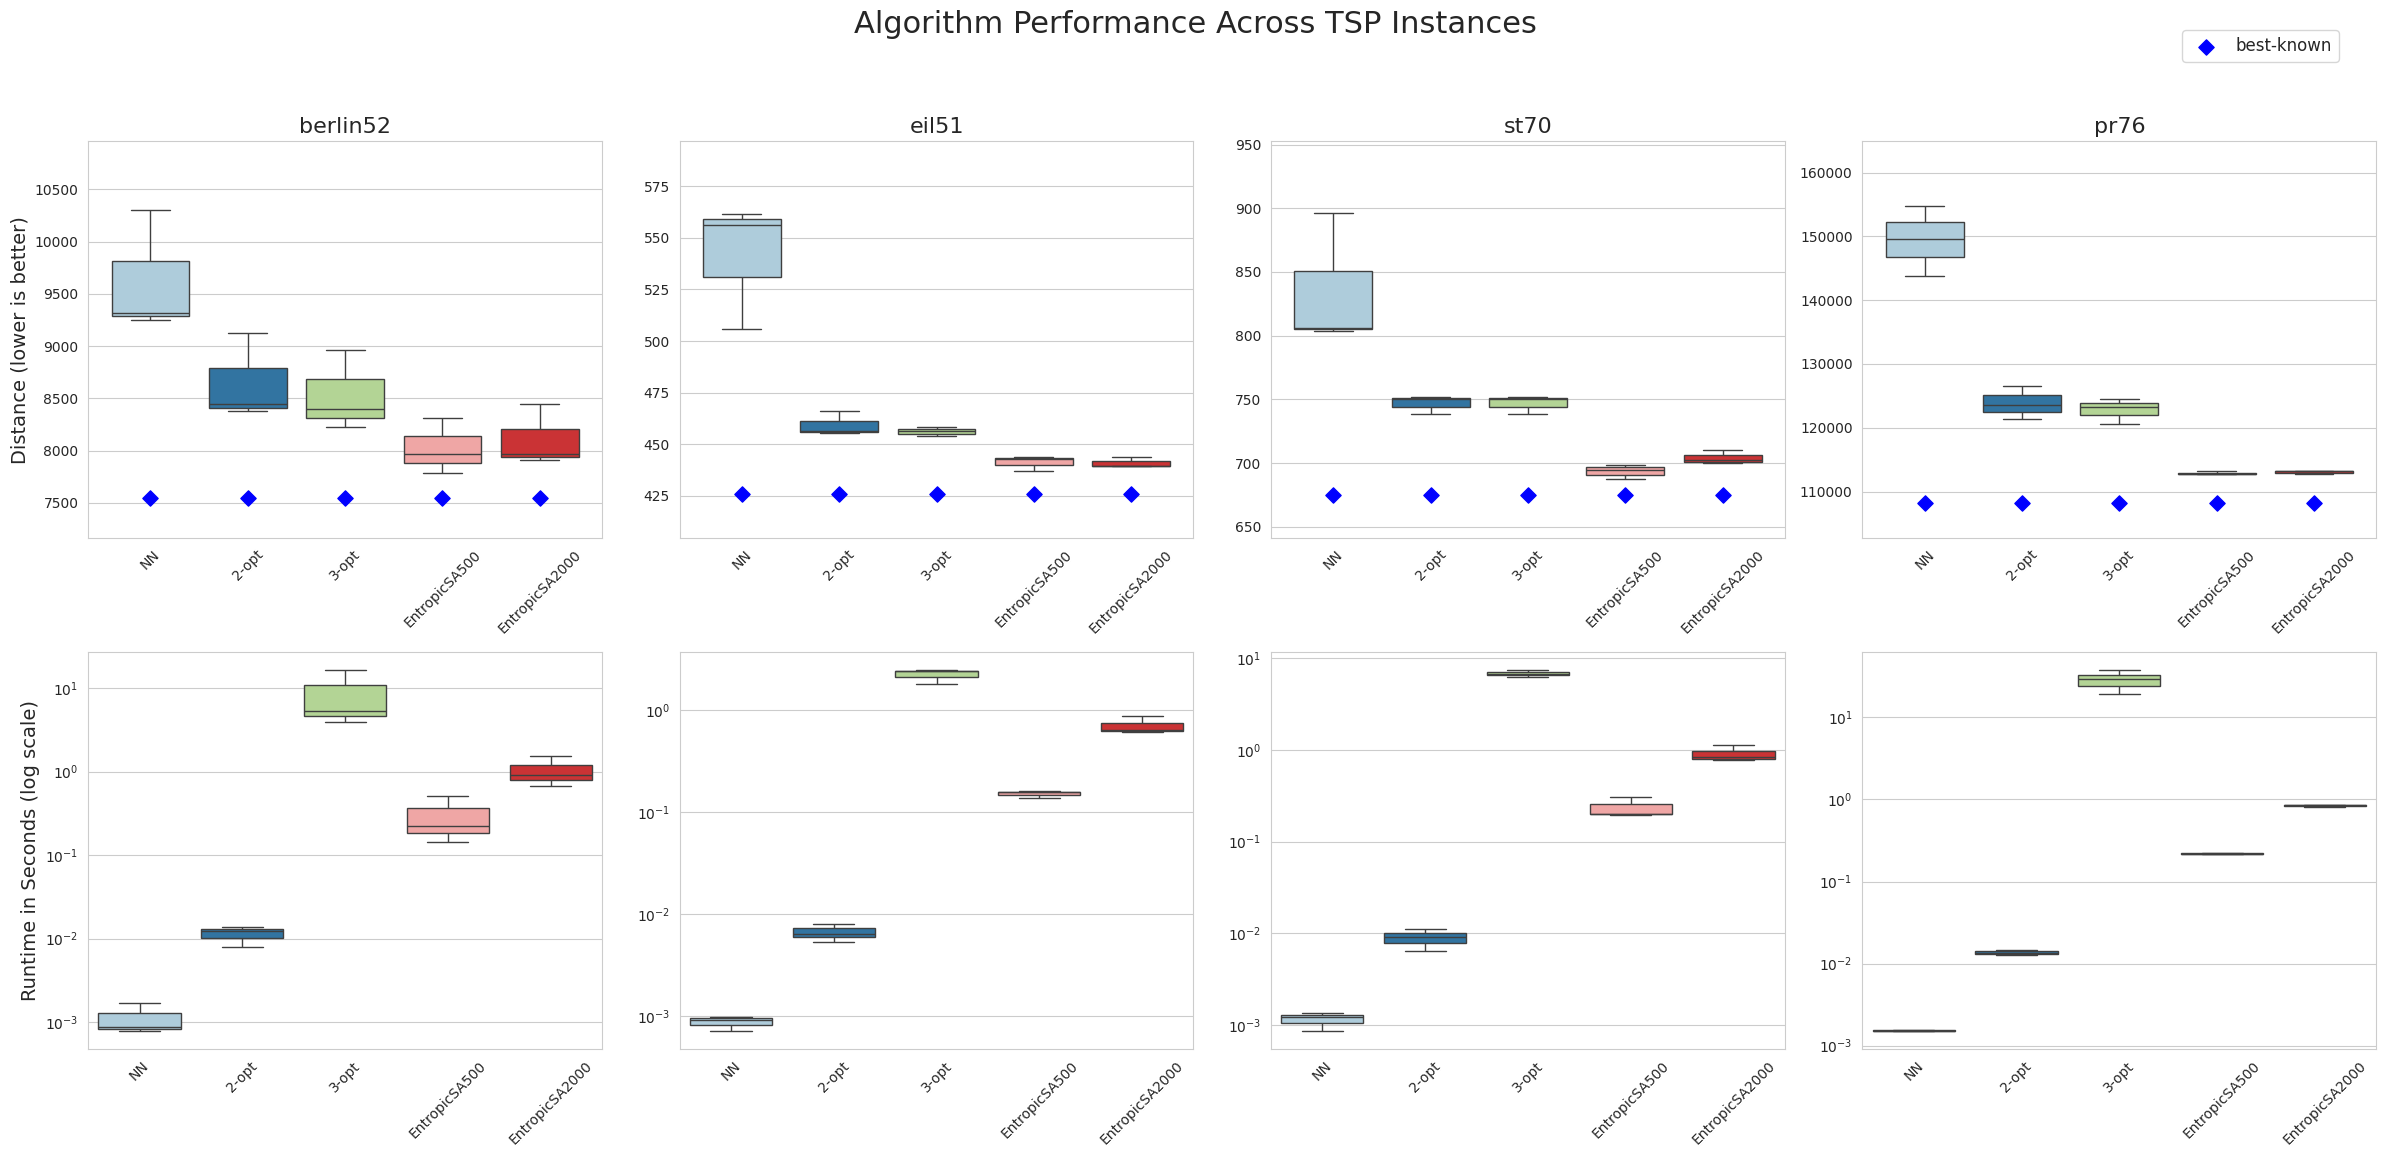

In [1]:
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.special import softmax
from tqdm import tqdm
from IPython.display import display

# ─── 1. Embedded TSPLIB Data ──────────────────────────────────────────
berlin52_tsp = """
NAME: berlin52
TYPE: TSP
COMMENT: 52 locations in Berlin (Groetschel)
DIMENSION: 52
EDGE_WEIGHT_TYPE: EUC_2D
NODE_COORD_SECTION
1 565.0 575.0
2 25.0 185.0
3 345.0 750.0
4 945.0 685.0
5 845.0 655.0
6 880.0 660.0
7 25.0 230.0
8 525.0 1000.0
9 580.0 1175.0
10 650.0 1130.0
11 1605.0 620.0
12 1220.0 580.0
13 1465.0 200.0
14 1530.0 5.0
15 845.0 680.0
16 725.0 370.0
17 145.0 665.0
18 415.0 635.0
19 510.0 875.0
20 560.0 365.0
21 300.0 465.0
22 520.0 585.0
23 480.0 415.0
24 835.0 625.0
25 975.0 580.0
26 1215.0 245.0
27 1320.0 315.0
28 1250.0 400.0
29 660.0 180.0
30 410.0 250.0
31 420.0 555.0
32 575.0 665.0
33 1150.0 1160.0
34 700.0 580.0
35 685.0 595.0
36 685.0 610.0
37 770.0 610.0
38 795.0 645.0
39 720.0 635.0
40 760.0 650.0
41 475.0 960.0
42 95.0 260.0
43 875.0 920.0
44 700.0 500.0
45 555.0 815.0
46 830.0 485.0
47 1170.0 65.0
48 830.0 610.0
49 605.0 625.0
50 595.0 360.0
51 1340.0 725.0
52 1740.0 245.0
EOF
"""
eil51_tsp = """
NAME : eil51
COMMENT : 51-city problem (Christofides/Eilon)
TYPE : TSP
DIMENSION : 51
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 37 52
2 49 49
3 52 64
4 20 26
5 40 30
6 21 47
7 17 63
8 31 62
9 52 33
10 51 21
11 42 41
12 31 32
13 5 25
14 12 42
15 36 16
16 52 41
17 27 23
18 17 33
19 13 13
20 57 58
21 62 42
22 42 57
23 16 57
24 8 52
25 7 38
26 27 68
27 30 48
28 43 67
29 58 48
30 58 27
31 37 69
32 38 46
33 46 10
34 61 33
35 62 63
36 63 69
37 32 22
38 45 35
39 59 15
40 5 6
41 10 17
42 21 10
43 5 64
44 30 15
45 39 10
46 32 39
47 25 32
48 25 55
49 48 28
50 56 37
51 30 40
EOF
"""
st70_tsp = """
NAME: st70
TYPE: TSP
COMMENT: 70-city problem (Smith/Thompson)
DIMENSION: 70
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 64 96
2 80 39
3 69 23
4 72 42
5 48 67
6 58 43
7 81 34
8 79 17
9 30 23
10 42 67
11 7 76
12 29 51
13 78 92
14 64 8
15 95 57
16 57 91
17 40 35
18 68 40
19 92 34
20 62 1
21 28 43
22 76 73
23 67 88
24 93 54
25 6 8
26 87 18
27 30 9
28 77 13
29 78 94
30 55 3
31 82 88
32 73 28
33 20 55
34 27 43
35 95 86
36 67 99
37 48 83
38 75 81
39 8 19
40 20 18
41 54 38
42 63 36
43 44 33
44 52 18
45 12 13
46 25 5
47 58 85
48 5 67
49 90 9
50 41 76
51 25 76
52 37 64
53 56 63
54 10 55
55 98 7
56 16 74
57 89 60
58 48 82
59 81 76
60 29 60
61 17 22
62 5 45
63 79 70
64 9 100
65 17 82
66 74 67
67 10 68
68 48 19
69 83 86
70 84 94
EOF
"""
pr76_tsp = """
NAME : pr76
COMMENT : 76-city problem (Padberg/Rinaldi)
TYPE : TSP
DIMENSION : 76
EDGE_WEIGHT_TYPE : EUC_2D
NODE_COORD_SECTION
1 3600 2300
2 3100 3300
3 4700 5750
4 5400 5750
5 5608 7103
6 4493 7102
7 3600 6950
8 3100 7250
9 4700 8450
10 5400 8450
11 5610 10053
12 4492 10052
13 3600 10800
14 3100 10950
15 4700 11650
16 5400 11650
17 6650 10800
18 7300 10950
19 7300 7250
20 6650 6950
21 7300 3300
22 6650 2300
23 5400 1600
24 8350 2300
25 7850 3300
26 9450 5750
27 10150 5750
28 10358 7103
29 9243 7102
30 8350 6950
31 7850 7250
32 9450 8450
33 10150 8450
34 10360 10053
35 9242 10052
36 8350 10800
37 7850 10950
38 9450 11650
39 10150 11650
40 11400 10800
41 12050 10950
42 12050 7250
43 11400 6950
44 12050 3300
45 11400 2300
46 10150 1600
47 13100 2300
48 12600 3300
49 14200 5750
50 14900 5750
51 15108 7103
52 13993 7102
53 13100 6950
54 12600 7250
55 14200 8450
56 14900 8450
57 15110 10053
58 13992 10052
59 13100 10800
60 12600 10950
61 14200 11650
62 14900 11650
63 16150 10800
64 16800 10950
65 16800 7250
66 16150 6950
67 16800 3300
68 16150 2300
69 14900 1600
70 19800 800
71 19800 10000
72 19800 11900
73 19800 12200
74 200 12200
75 200 1100
76 200 800
EOF
"""

def parse_tsp(text):
    coords, reading_coords = [], False
    for line in text.strip().splitlines():
        if line.strip().startswith("NODE_COORD_SECTION"): reading_coords = True; continue
        if line.strip().startswith("EOF"): break
        if reading_coords:
            parts = line.split()
            coords.append((float(parts[1]), float(parts[2])))
    return coords

instances_data = {
    "berlin52": parse_tsp(berlin52_tsp), "eil51": parse_tsp(eil51_tsp),
    "st70": parse_tsp(st70_tsp), "pr76": parse_tsp(pr76_tsp),
}
best_known = {"berlin52": 7542, "eil51": 426, "st70": 675, "pr76": 108159}

# ─── 2. TSP ALGORITHMS ──────────────────────────────────────────────────
class City:
    __slots__ = ("x", "y", "v")
    def __init__(self, x: float, y: float): self.x, self.y, self.v = x, y, False

def dist(c1, c2): return math.hypot(c1.x - c2.x, c1.y - c2.y)
def tour_len(tour): return sum(dist(tour[i], tour[i-1]) for i in range(len(tour)))

def nn(cities):
    for c in cities: c.v = False
    start_city = random.choice(cities)
    tour, current_city = [start_city], start_city
    start_city.v = True
    while len(tour) < len(cities):
        next_city = min((c for c in cities if not c.v), key=lambda c: dist(current_city, c))
        next_city.v = True
        tour.append(next_city)
        current_city = next_city
    return tour

def two_opt(tour):
    path, n = tour[:], len(tour)
    improved = True
    while improved:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n):
                if j - i == 1: continue
                # Check if reversing the segment between i and j-1 is an improvement
                if dist(path[i-1], path[j-1]) + dist(path[i], path[j]) < dist(path[i-1], path[i]) + dist(path[j-1], path[j]):
                    path[i:j] = path[j-1:i-1:-1] # This is the 2-opt swap
                    improved = True
    return path

def three_opt(tour):
    """
    First-improvement 3-opt local search.
    Works on a *cyclic* tour represented as a list of City objects.
    Returns the (possibly) improved tour.
    """
    n = len(tour)
    best_len = tour_len(tour)

    while True:                                     # repeat until no-improvement pass
        improved = False

        # choose three non-adjacent break points i<j<k
        for i in range(n - 5):
            for j in range(i + 2, n - 3):
                for k in range(j + 2, n - (i == 0) - 1):
                    # segments: S = tour[ :i+1] , A = i+1..j , B = j+1..k , C = k+1..
                    A = tour[i + 1 : j + 1]
                    B = tour[j + 1 : k + 1]
                    S = tour[: i + 1]
                    C = tour[k + 1 :]

                    cand_tours = (
                        S + A[::-1] + B + C,          # case 1
                        S + A + B[::-1] + C,          # case 2
                        S + A[::-1] + B[::-1] + C,    # case 3
                        S + B + A + C,                # case 4
                        S + B[::-1] + A + C,          # case 5
                        S + B + A[::-1] + C,          # case 6
                        S + B[::-1] + A[::-1] + C,    # case 7
                    )

                    # evaluate candidates in order; accept first improvement
                    for cand in cand_tours:
                        cand_len = tour_len(cand)
                        if cand_len < best_len - 1e-12:   # numerical guard
                            tour, best_len = cand, cand_len
                            improved = True
                            break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break

        if not improved:                                # no move found – local optimum
            return tour



def calculate_distance(route_indices, distance_matrix):
    return distance_matrix[route_indices, np.roll(route_indices, -1)].sum()

def two_opt_swap(route_indices, i, k):
    return np.concatenate((route_indices[:i], route_indices[i:k+1][::-1], route_indices[k+1:]))


def entropic_sa(distance_matrix, initial_route_indices, max_iterations=1000):
    current_route, n = np.array(initial_route_indices), len(initial_route_indices)
    best_route = np.copy(current_route)
    current_distance = calculate_distance(current_route, distance_matrix)
    best_distance = current_distance
    temperature, cooling_rate, min_temperature = 10.0, 0.995, 0.1

    for _ in range(max_iterations):
        distance_deltas, potential_swaps = [], []
        for _ in range(n):
            i = random.randint(1, n - 2)
            k = random.randint(i + 1, n - 1)
            old_dist = distance_matrix[current_route[i-1], current_route[i]] + distance_matrix[current_route[k], current_route[(k+1)%n]]
            new_dist = distance_matrix[current_route[i-1], current_route[k]] + distance_matrix[current_route[i], current_route[(k+1)%n]]
            distance_deltas.append(new_dist - old_dist)
            potential_swaps.append((i, k))

        probabilities = softmax(-np.array(distance_deltas) / temperature)
        selected_index = np.random.choice(len(potential_swaps), p=probabilities)
        i, k = potential_swaps[selected_index]
        new_route = two_opt_swap(current_route, i, k)
        new_distance = calculate_distance(new_route, distance_matrix)

        if new_distance < current_distance or random.random() < math.exp((current_distance - new_distance) / temperature):
            current_route, current_distance = new_route, new_distance
            if new_distance < best_distance:
                best_distance, best_route = new_distance, np.copy(new_route)
        temperature = max(min_temperature, temperature * cooling_rate)
    return best_route.tolist()

# ─── 3. BENCHMARKING & DATA COLLECTION ──────────────────────────────────
loops_set = [500, 2000]
runs = 3
records = []

for inst, coords in tqdm(instances_data.items(), desc="Processing Instances"):
    master_cities = [City(x, y) for x, y in coords]
    distance_matrix = cdist(np.array(coords), np.array(coords))
    city_to_idx = {id(c): i for i, c in enumerate(master_cities)}

    for r in tqdm(range(runs), desc=f"Runs for {inst}", leave=False):
        random.seed(6000 + r)
        shuffled_cities = random.sample(master_cities, len(master_cities))

        start_nn = time.perf_counter(); tour_nn = nn(shuffled_cities); time_nn = time.perf_counter() - start_nn
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_nn), "algo": "NN"})
        records.append({"instance": inst, "metric": "runtime", "value": time_nn, "algo": "NN"})

        start_2opt = time.perf_counter(); tour_2opt = two_opt(tour_nn); time_2opt = time.perf_counter() - start_2opt
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_2opt), "algo": "2-opt"})
        records.append({"instance": inst, "metric": "runtime", "value": time_2opt, "algo": "2-opt"})

        start_3opt = time.perf_counter(); tour_3opt = three_opt(tour_2opt); time_3opt = time.perf_counter() - start_3opt
        records.append({"instance": inst, "metric": "distance", "value": tour_len(tour_3opt), "algo": "3-opt"})
        records.append({"instance": inst, "metric": "runtime", "value": time_3opt, "algo": "3-opt"})

        for loops in loops_set:
            start_pipeline = time.perf_counter()
            initial_indices = [city_to_idx[id(c)] for c in tour_3opt] # Use 3-opt result as input
            sa_indices = entropic_sa(distance_matrix, initial_indices, max_iterations=loops)
            sa_tour = [master_cities[i] for i in sa_indices]
            final_polished_tour = two_opt(sa_tour)
            time_pipeline = time.perf_counter() - start_pipeline
            algo_name = f"EntropicSA{loops}"
            records.append({"instance": inst, "metric": "distance", "value": tour_len(final_polished_tour), "algo": algo_name})
            records.append({"instance": inst, "metric": "runtime", "value": time_pipeline, "algo": algo_name})

df = pd.DataFrame(records)

# ─── 4. PLOTTING ────────────────────────────────────────────────────────
algo_order = ["NN", "2-opt", "3-opt", "EntropicSA500", "EntropicSA2000"]
palette = {"NN": "#a6cee3", "2-opt": "#1f78b4", "3-opt": "#b2df8a", "EntropicSA500": "#fb9a99", "EntropicSA2000": "#e31a1c"}

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for col, inst in enumerate(instances_data.keys()):
    axd = axes[0, col]
    subset_dist = df[(df.instance == inst) & (df.metric == "distance")]
    sns.boxplot(data=subset_dist, x="algo", y="value", order=algo_order, palette=palette, ax=axd)
    goal = best_known[inst]
    axd.scatter(range(len(algo_order)), [goal] * len(algo_order), color="blue", marker="D", s=60, zorder=5, label="best-known" if col == 0 else "")
    lo, hi = axd.get_ylim()
    axd.set_ylim(min(lo, goal * 0.95), hi * 1.05)
    axd.set_title(inst, fontsize=16)
    axd.set_xlabel("")
    axd.set_ylabel("")
    axd.tick_params(axis='x', rotation=45)

    axr = axes[1, col]
    subset_time = df[(df.instance == inst) & (df.metric == "runtime")]
    sns.boxplot(data=subset_time, x="algo", y="value", order=algo_order, palette=palette, ax=axr)
    axr.set_xlabel("")
    axr.set_ylabel("")
    axr.set_yscale('log')
    axr.tick_params(axis='x', rotation=45)

axes[0, 0].set_ylabel("Distance (lower is better)", fontsize=14)
axes[1, 0].set_ylabel("Runtime in Seconds (log scale)", fontsize=14)
handles, labels = axes[0, 0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="upper right", fontsize=12, bbox_to_anchor=(0.98, 0.98))

fig.suptitle("Algorithm Performance Across TSP Instances", fontsize=22, y=0.99)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ─── 5. DATA TABLE SUMMARY  ────────────────────────────────────────────
dist_df    = df[df['metric'] == 'distance']
runtime_df = df[df['metric'] == 'runtime']

stats = ['mean', 'median', 'min', 'max']
dist_summary    = dist_df.groupby(['instance', 'algo'])['value'].agg(stats)
runtime_summary = runtime_df.groupby(['instance', 'algo'])['value'].agg(stats)

# Concatenate the two summaries side-by-side
summary_table = pd.concat({'Distance': dist_summary,
                           'Runtime' : runtime_summary}, axis=1)

# Put the statistic (mean / median / …) in the *outer* level – easier to scan
summary_table = summary_table.reorder_levels([1, 0], axis=1).sort_index(axis=1)

# Style: colour only the “mean” column of each metric
styled_table = (
    summary_table.style
        .set_caption("Algorithm Performance Summary (lower is better)")
        .background_gradient(
            cmap='viridis_r',
            subset=pd.IndexSlice[:, pd.IndexSlice['mean', :]]  # first-level “mean”
        )
        .format("{:,.2f}")
)

display(styled_table)